# Changing Profiles (RR)

## Setup

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import glob
import numpy as np
import sys, os
import netCDF4 as nc
import xarray as xr
from IPython import display
from numpy import loadtxt
from tqdm.notebook import trange, tqdm
from time import sleep

from mpl_toolkits.basemap import Basemap
from pyresample import kd_tree,geometry
from pyresample import load_area, save_quicklook, SwathDefinition

In [2]:
# Function for supressing output of function
# used to mute the object called everytime the SMRT is run

from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [3]:
directory = '../RR_OIB/'
files = glob.glob(directory + '*.text')

#RR_list = [0,1,6,4,29,84,95,85,96,61,56] # old
RR_list = [0,1,6,4,29,50,51,54,55,56,57,60,61,62,63]

count = 0
RR = []
prnt = False

for p in range(len(files)):
    
    with open(files[p], 'r') as the_file:
        all_data = [line.strip() for line in the_file.readlines()]
        header = all_data[1].split(',')
        data = all_data[2:]
    
        Data = np.zeros((len(data),len(header)))
    
        for i in range(len(data)):
        
            d = data[i].split(',')
        
            for j in range(np.size(Data[0])):
            
                try:
                    Data[i,j] = d[j]
                except:
                    pass

            #for i in range(len(header)):
            if Data[i,[4,6,84,95]].all():
                count += 1

                #useful[i,:] = Data[i,[0,1,6,4,29,84,95,85,96,61,56]]
                
                try:
                    RR = np.concatenate((RR,np.array([Data[i,RR_list]])))
                except:
                    RR = np.array([Data[i,RR_list]])
                                    
                if prnt:
                    print('File number:',p,',',i)
                    for k in np.array(RR_list):
                        print('')
                        print(header[k])
                        print(Data[i,k])
                    print('\n')

In [4]:
def ArcticPlot(lat,lon,data,*C):   
    
    d = data
    
    Data = np.ma.array(d,   mask = d < .1)
    Lats = np.ma.array(lat, mask = d < .1)
    Lons = np.ma.array(lon, mask = d < .1)
    
    if len(C) != 2:
        C = [np.min(Data),np.max(Data)]
        
    # res = crude,low,intermediate,high,full
    m = Basemap(projection='npstere',boundinglat=60.0,lon_0=360.0,resolution='c',area_thresh=50000)
    
    # Settings for plot
    m.drawparallels(range(0, 180, 10))
    m.drawmeridians(range(0, 360, 30))
    m.drawmapboundary(fill_color='lightgray')
    m.fillcontinents(color='darkgray',lake_color='gray')
    m.drawcoastlines(linewidth=0.15)
 
    # add temperature data as scatter-plot on map
    x,y = m(Lons,Lats)
    m.scatter(x,y,c=Data,vmin=C[0], vmax=C[1],cmap=plt.cm.jet,edgecolors=None,s=0.15)
    # Brug måske pcolormesh

In [5]:
#tie-point model for ice and open water
def tiepoint(snedybde, istykkelse, overfladetemperatur, iskoncentration):
    #the mar+april 2013 model
    #Tb for sea ice
    #overfladetemperatur [K]
    #snedybde [m]
    #istykkelse [m]
    #iskoncentration [0-1]
    T6vsi = 151.981 + 0.398 * overfladetemperatur+ 23.360 * snedybde -3.031 * istykkelse
    T6hsi = 55.262 + 0.687 * overfladetemperatur+ 12.962 * snedybde -1.664 * istykkelse
    T10vsi = 145.878 + 0.435 * overfladetemperatur+ 0.743 * snedybde -4.202 * istykkelse
    T10hsi = 45.107 + 0.753 * overfladetemperatur -18.7322 * snedybde -3.490 * istykkelse
    T18vsi = 138.073 + 0.479 * overfladetemperatur -71.814 * snedybde -5.570 * istykkelse
    T18hsi = 78.424 + 0.641 * overfladetemperatur -85.184 * snedybde -5.341 * istykkelse
    T36vsi = 123.102 + 0.526 * overfladetemperatur -216.727 * snedybde -4.036 * istykkelse
    T36hsi = 131.862 + 0.429 * overfladetemperatur -214.352 * snedybde -3.035 * istykkelse
    T89vsi = 2.525 + 0.902 * overfladetemperatur -180.427 * snedybde+ 1.904 * istykkelse
    T89hsi = 31.120 + 0.743 * overfladetemperatur -184.806 * snedybde+ 3.197 * istykkelse
    #Tb for open water
    T6vow=161.35
    T6how=82.13
    T10vow=167.34
    T10how=88.26
    T18vow=183.72
    T18how=108.46
    T36vow=196.41
    T36how=128.23
    T89vow=243.20
    T89how=196.94
    #Tb for ice and open water
    T6vsim  = iskoncentration*T6vsi  + (1-iskoncentration)*T6vow
    T6hsim  = iskoncentration*T6hsi  + (1-iskoncentration)*T6how
    T10vsim = iskoncentration*T10vsi + (1-iskoncentration)*T10vow
    T10hsim = iskoncentration*T10hsi + (1-iskoncentration)*T10how
    T18vsim = iskoncentration*T18vsi + (1-iskoncentration)*T18vow
    T18hsim = iskoncentration*T18hsi + (1-iskoncentration)*T18how
    T36vsim = iskoncentration*T36vsi + (1-iskoncentration)*T36vow
    T36hsim = iskoncentration*T36hsi + (1-iskoncentration)*T36how    
    T89vsim = iskoncentration*T89vsi + (1-iskoncentration)*T89vow
    T89hsim = iskoncentration*T89hsi + (1-iskoncentration)*T89how    
        
    Tbv=np.array([T6vsim,T10vsim,T18vsim,T36vsim,T89vsim])
    Tbh=np.array([T6hsim,T10hsim,T18hsim,T36hsim,T89hsim])
    return Tbv, Tbh

In [6]:
sys.path.append("/Users\fnifd\Documents\BachelorProject\smrt\smrt-master")

# local import
from smrt import make_ice_column, make_snowpack, make_model, sensor_list
from smrt import PSU
from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09


# create the sensor
sensor = sensor_list.amsre()

#n_max_stream = 128 #TB calculation is more accurate if number of streams is increased (currently: default = 32);
n_max_stream=32
#needs to be increased when using > 1 snow layer on top of sea ice! normalization="forced"from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09

def run_smrt(snow_depth,ice_thickness,surf_temp,ice_type):

    #smrt_profile inputs: snow depth, ice thickness, surface temperature, ice type, returns profiles
    [num, di, Ti, Wi, roi, pci, sal, typei, si] = smrt_profile(snow_depth,ice_thickness,surf_temp,ice_type)
    #split into snow and sea ice indices
    snow=(si==0)
    ice=(si==1)


    ice_column = make_ice_column(ice_type=ice_type,
                            salinity=sal[ice]*PSU, 
                            microstructure_model="exponential",
                            background_permittivity_model=1.0,
                            brine_inclusion_shape="spheres", 
                            density = roi[ice],
                            thickness=di[ice],
                            temperature=Ti[ice],
                            corr_length=pci[ice]*1e-3,
                            add_water_substrate="ocean"
                            )

    
    snowpack = make_snowpack(thickness=di[snow],
                         microstructure_model="exponential",
                         density=roi[snow],
                         temperature=Ti[snow],
                         corr_length=pci[snow]*1e-3,
                         salinity=sal[snow]*PSU,
                         ice_permittivity_model=saline_snow_permittivity_geldsetzer09)
    

    #add snowpack on top of ice column:
    medium = snowpack + ice_column

    m = make_model("iba", "dort", rtsolver_options ={"n_max_stream": n_max_stream})

    # run the model for snow-covered sea ice:
    brightness_temperatures = m.run(sensor, medium)

    # print TBs at horizontal and vertical polarization Tb's:
    #print(brightness_temperatures.TbH(), brightness_temperatures.TbV())
    tbv=brightness_temperatures.TbV()
    tbh=brightness_temperatures.TbH()
    tv_no23=np.array([tbv[0],tbv[1],tbv[2],tbv[4],tbv[5]])
    th_no23=np.array([tbh[0],tbh[1],tbh[2],tbh[4],tbh[5]])
    return tv_no23, th_no23

In [7]:
def RRmodel(RoundRobin):
        
    lat           = RoundRobin[0]
    lon           = RoundRobin[1]
    IceThickness  = RoundRobin[2]
    SnowThickness = RoundRobin[3]
    SurfaceTemp   = RoundRobin[4]
    
    if np.floor(SnowThickness*100) > 0:
                                        
        if IceThickness >= 1.5:
            ice_type = 'multiyear'
        else:
            ice_type = 'firstyear'
            
        #TbV,TbH     = tiepoint(SnowThickness,IceThickness,SurfaceTemp,iceConc)                                                                                            
        #mrtV,smrtH = run_smrt(SnowThickness,IceThickness,SurfaceTemp,ice_type)

        try:
            TbV,TbH     = tiepoint(SnowThickness,IceThickness,SurfaceTemp,iceConc)
            with suppress_stdout():
                smrtV,smrtH = run_smrt(SnowThickness,IceThickness,SurfaceTemp,ice_type)
        except:
            print('error')
                
    return TbV,TbH,smrtV,smrtH

In [8]:
def meanDiff():
    
    BT_V = smrtV[:,:] - RR[:,[6,8,10,12,14]]
    BT_H = smrtH[:,:] - RR[:,[5,7,9,11,13]]
    
    V_avg = BT_V.mean(0)
    H_avg = BT_H.mean(0)

    score = (V_avg.mean()+H_avg.mean())/2
    
    return score,BT_V,BT_H

In [9]:
freqs = np.array([6,10,18,36,89])
jump = 1
iceConc = 1
RR_len = len(RR[:,0])

## Make profile

In [10]:
def smrt_profile(snowt,icet,Ts,icetype):
    #snowt: snow thickness [m]
    #icet: ice thickness [m]
    #Ts: thermometric temperature of the surface
    #icetype: first- or multiyear ice ['firstyear'/'multiyear']
    
    
        
    #compute num: layer number, top to bottom
    #total depth in cm
    hs=int(np.floor(snowt*100))
    hi=int(np.floor(icet*100))
    
    total_depth=int(hs+hi)
    
    num=np.array(range(total_depth))
    num=num+1
    #num = np.array(range(3))+1
    
    #compute layer thickness
    di=np.ones(total_depth)
    
    #comute the thermometric temperature
    Ti=np.zeros(int(total_depth))
    snowtemp=np.zeros(hs)
    icetemp=np.zeros(hi)
    Tw=271.35
    ks=0.3
    ki=2.1
    #snedybden skal ikke være null her
    f=(ks*hi)/(ki*hs) 
    Tsi=(Tw+f*Ts)/(f+1)
    
    for i in range(hs):
        snowtemp[i]=Ts+i*(Tsi-Ts)/hs
    for j in range(hi):
        icetemp[j]=Tsi+j*(Tw-Tsi)/hi
        Ti[0:hs]=snowtemp[:]
        Ti[hs:hs+hi]=icetemp[:]
        
    #water content in the snow
    Wi=np.zeros(total_depth)
    
    #density profile : cox & weeks sammenhaeng mellem massefylde og saltindhold
    roi=np.zeros(total_depth)
    #snow density
    snow_density=np.ones(hs)
    w=int((np.floor(hs/4)))
    if hs < 4: snow_density[:]=330.0
    else:
        snow_density[0:w]=200.0
        snow_density[w:]=400.0
        snow_density=np.flipud(snow_density)
        
    ice_density=np.zeros(hi)
    #First-year ice density (icethickness)
    if icetype=='firstyear': 
        ice_density[:]=726.0
        
    #Multiyear ice density Hummock (icethickness)
    if icetype=='multiyear':
        tdens=842.0
        bdens=910.0
        for i in range(hi):
            
            if i < 20:
                ice_density[i] = tdens+i*(bdens-tdens)/20 
            else:
                ice_density[i] = bdens
        
        
    roi[0:hs]=snow_density[:]
    roi[hs:hs+hi]=ice_density[:]
    
    #the scattering correlation length
    snow_grain_size = 10
    pci=np.zeros(total_depth)
    snow_pcc=np.zeros(hs)
    ice_pcc=np.zeros(hi)
    for i in range(hs):
        snow_pcc[i] = 0.01*snow_grain_size*np.exp(-3.0*(i/hs))+0.07
    snow_pcc=np.flipud(snow_pcc)
    if icetype=='firstyear': ice_pcc[:]=0.1
    elif icetype=='multiyear': 
        ice_pcc[0:20]=0.8
        ice_pcc[20:hi]=0.2
    pci[0:hs]=snow_pcc[:]
    pci[hs:hi+hs]=ice_pcc[:]
    
    #the salinity
    snow_sal=np.zeros(hs)
    ice_sal=np.zeros(hi)
    simt=np.zeros(hi)
    sal=np.zeros(total_depth)
    CW2=7.88-1.59*(hi/100.0)
    
    #First-year ice snow and ice salinity
    if icetype=='firstyear':
        for i in range(hs):
            snow_sal[i] = 2*CW2*np.exp(-10.0*(i/hs))
        for j in range(hi):
            ice_sal[j]=(2*CW2*np.exp(-5*j/hi)+10.0*j/hi)*np.exp(-8.0*j/hi)+np.exp(2.5*j/hi)
    elif icetype=='multiyear':
        tsal=0.0
        bsal=5.0
        snow_sal[:]=0.0
        for j in range(hi):
            ice_sal[j]=tsal+j*(bsal-tsal)/hi
    sal[0:hs]=np.flipud(snow_sal[:])
    sal[hs:hi+hs]=ice_sal[:]
   
    typei=np.ones(total_depth)
    snow_type=np.ones(hs)
    idx=(snow_pcc > 0.2)
    snow_type[idx]=2.0
    ice_type=np.ones(hi)
    if icetype=='firstyear': ice_type[:]=3
    elif icetype=='multiyear': ice_type[:]=4
    
    typei[0:hs]=snow_type[:]
    typei[hs:hs+hi]=ice_type[:]
    
    si=np.zeros(total_depth)
    si[hs:hs+hi]=1.0
    
    out = [num, di, Ti, Wi, roi, pci, sal, typei, si]
    hs2 = round(hs/2)    

    for i in range(len(out)):    
        out[i] = np.array([np.mean(out[i][0:hs2]),np.mean(out[i][hs2:hs]),np.mean(out[i][hs:])])
    
    return out

In [11]:
TbV,TbH,smrtV,smrtH = [np.empty([RR_len,len(freqs)]) for _ in range(4)]

for i in trange(RR_len,desc='run boi, run! '):
    TbV[i,:],TbH[i,:],smrtV[i,:],smrtH[i,:] = RRmodel(RR[i,:])

run boi, run! :   0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\fnifd\anaconda3\envs\Bachelor_4\lib\site-packages\smrt\permittivity\saline_snow.py:29: UserWarning: The permittivity model of Geldsetzer et al. 2009 (doi:10.1016/j.coldregions.2009.03.009) was developed for the frequency range 10 MHz - 40 GHz.
  warnings.warn(


In [12]:
TbV

array([[252.90155, 246.79771, 224.88364, 179.66579, 175.65711],
       [249.1125 , 244.02594, 226.99143, 194.44529, 191.79289],
       [246.37603, 239.65897, 219.79656, 185.84685, 189.60929],
       [248.76898, 242.26768, 221.73513, 184.07401, 185.53985],
       [247.35178, 242.06487, 225.25657, 194.58464, 192.94364],
       [248.48273, 242.30052, 222.60134, 186.17502, 186.25974],
       [248.07921, 240.54782, 217.4266 , 175.72686, 179.16886],
       [246.18529, 237.27068, 211.61096, 168.24768, 177.22784],
       [248.22371, 240.35116, 216.37057, 173.43821, 178.21545],
       [249.46182, 241.07631, 215.11269, 167.65044, 172.87984],
       [248.08378, 238.4875 , 210.18702, 160.85728, 170.87972],
       [248.025  , 237.83856, 207.9255 , 155.82458, 166.95646],
       [249.51938, 241.77727, 217.48807, 172.68334, 176.27394],
       [247.41361, 238.3664 , 211.6289 , 164.9275 , 172.88774],
       [247.40656, 237.35716, 208.06515, 157.48143, 168.41495],
       [249.00193, 239.12752, 210.04287,

In [12]:
score,BT_V,BT_H = meanDiff()
print(np.mean(BT_V),np.mean(BT_H))
print(score)

27.430490075094088 21.799738381823058
24.615114228458573


In [15]:
BT_V

array([[11.93265961, 15.88675412, 27.37052404, 49.73948028, 33.52265183],
       [10.75743226, 14.6362352 , 25.66908215, 45.92151319, 31.55155897],
       [ 9.93157417, 14.98094465, 26.32396636, 45.88157777, 30.74240546],
       [11.27524755, 15.11447172, 25.59981272, 43.58143734, 28.01222586],
       [ 9.96939559, 14.58383371, 25.7755756 , 44.72074126, 27.97270249],
       [11.64320524, 16.02459413, 26.81337789, 44.44680697, 27.01760439],
       [12.42052732, 17.9572181 , 30.55509221, 50.72798461, 32.84083829],
       [12.58318331, 18.50416438, 31.00076436, 50.43867771, 31.79312354],
       [13.89834558, 20.13097585, 32.65891346, 51.31537905, 32.0628011 ],
       [14.69251684, 21.39322547, 35.28117664, 55.07637448, 35.30886542],
       [13.98736043, 20.52423847, 35.04928493, 56.25013102, 35.3821993 ],
       [14.03198221, 21.15657651, 36.21656655, 57.69410418, 35.10504196],
       [14.65227813, 21.43338814, 37.03274065, 58.15212993, 35.08834176],
       [13.24488869, 20.46558516, 35.7

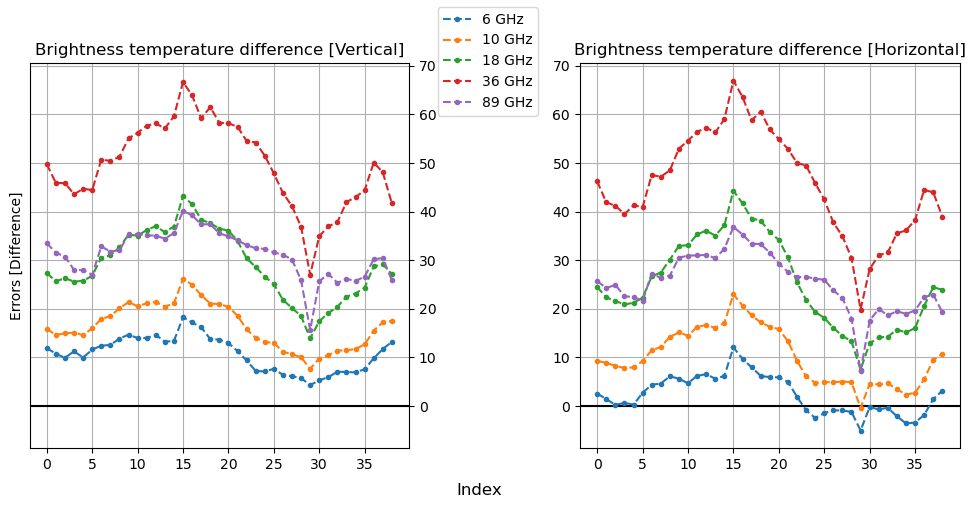

In [14]:

fig, (ax1,ax2)= plt.subplots(1,2,figsize=(12,5),sharey = True)

plt.subplot(121)
plt.axhline(c = 'k')
plt.plot(BT_V,'.--',label=(['6 GHz','10 GHz','18 GHz','36 GHz','89 GHz']))
plt.title('Brightness temperature difference [Vertical]')
plt.grid()
plt.tick_params('y',left = False,labelleft = False,right = True,labelright = True)
plt.ylabel('Errors [Difference]')

# Model udregnet - RR faktisk bt

plt.subplot(122)
plt.axhline(c = 'k')
a = plt.plot(BT_H,'.--')
plt.title('Brightness temperature difference [Horizontal]')
plt.grid()
plt.tick_params('y',labelleft = True)

fig.legend(loc='upper center')
fig.supxlabel('Index')
fig.subplots_adjust(wspace=0.45)
plt.show()

In [53]:
ice_type = 'multiyear'
RoundRobin = RR[0,:]
lat           = RoundRobin[0]
lon           = RoundRobin[1]
IceThickness  = RoundRobin[2]
SnowThickness = RoundRobin[3]
SurfaceTemp   = RoundRobin[4]



In [107]:
[num, di, Ti, Wi, roi, pci, sal, typei, si] = smrt_profile(SnowThickness,IceThickness,SurfaceTemp,ice_type)

In [108]:
out = [num, di, Ti, Wi, roi, pci, sal, typei, si]

hs=int(np.floor(SnowThickness*100))
hs2 = round(hs/2)

np.mean(out[i][0:hs2])

1.0

In [109]:
for i in range(len(out)):    
    out[i] = np.array([np.mean(out[i][0:hs2]),np.mean(out[i][hs2:hs]),np.mean(out[i][hs:])])

out[:]

[array([  8.5,  24. , 127. ]),
 array([1., 1., 1.]),
 array([252.67753676, 258.37644608, 266.30764706]),
 array([0., 0., 0.]),
 array([330.        , 292.66666667, 906.2617801 ]),
 array([0.09499012, 0.18069901, 0.26282723]),
 array([0.        , 0.        , 2.48691099]),
 array([1.        , 1.33333333, 4.        ]),
 array([0., 0., 1.])]

In [110]:
out

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [70]:
int(np.floor(SnowThickness*100))

31

In [55]:
smrt_profile(SnowThickness,IceThickness,SurfaceTemp,ice_type)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

In [12]:
RoundRobin = RR[10,:]
lat           = RoundRobin[0]
lon           = RoundRobin[1]
IceThickness  = RoundRobin[2]
SnowThickness = RoundRobin[3]
SurfaceTemp   = RoundRobin[4]
    
if np.floor(SnowThickness*100) > 0:
                                        
    if IceThickness >= 1.5:
        ice_type = 'multiyear'
    else:
        ice_type = 'firstyear'
                                                                                                
    try:
        TbV,TbH     = tiepoint(SnowThickness,IceThickness,SurfaceTemp,iceConc)
        with suppress_stdout():
            smrtV,smrtH = run_smrt(SnowThickness,IceThickness,SurfaceTemp,ice_type)
    except:
        print('error')


In [13]:

print(SnowThickness)
print(IceThickness)
smrtV,smrtH = run_smrt(SnowThickness,IceThickness,SurfaceTemp,ice_type)


0.36
3.94
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001F862AF4C40>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001F862AF4C40>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001F862AF4C40>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001F862AF4C40>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001F862AF4C40>
SUBSTRATE: <smrt.substrate.flat.Flat object at 0x000001F862AF4C40>
